In [6]:
from selenium import webdriver
import time
import numpy as np
import pandas as pd
import random
from bs4 import BeautifulSoup
import requests
import fuckit #!pip install fuckit

# Web-scrape job posts on au.indeed.com

First, Selenium is used to automate the process of job searching with a certain salary range. This hidden salary range will serve as the true salary in modelling later. Selenium will retrieve all jobs' urls in `all_links`, and a separate list `all_salaries` stores the corresponding salary ranges. To speed up the scraping process, BeautifulSoup is used instead to go through each url and scarp the data, which is stored in a dataframe.

## Define helper functions for web-scraping 

In [2]:
def get_all_links(search,location,site='https://au.indeed.com/advanced_search'):
    '''
    Use Selenium to go through each search phrases based on a salary range
    Returns all jobs' urls and their corresponding salary range
    '''
    driver = webdriver.Chrome(executable_path=r"C:\Program Files (x86)\ChromeDriver\chromedriver.exe")
    all_links = []
    all_salaries = []
    # Search jobs by each salary_range (and other criteras), this range is its true, hidden salary 
    for s in range(lower,upper,step):
        salary_range = '$'+str(s)+'-$'+str(s+step-1)
        driver.get(site)
        driver.find_element_by_name('as_phr').send_keys(search) # exact phrase
        driver.find_element_by_name('salary').send_keys(salary_range)
        driver.find_element_by_name('l').send_keys(location)
        driver.find_element_by_xpath("//select[@name='limit']/option[text()='50']").click()
        driver.find_element_by_id('fj').click()

        while True:
            try:
                time.sleep(random.randrange(1500,3000)/1000)
                try: # Get rid of popup, ignore if it doesn't turn up
                    driver.find_element_by_xpath('//a[@class="icl-CloseButton popover-x-button-close"]').click()
                except:
                    pass

                links = driver.find_elements_by_xpath('//a[@data-tn-element="jobTitle"]')
                for i in range(len(links)): # Get all the urls in one page, append to master list all_links
                    all_links.append(links[i].get_attribute('href'))
                    all_salaries.append(salary_range)
                # Go to next page till no more nexts, throwing an error and breaking out the loop
                driver.find_element_by_xpath('//span[@class="pn"]/span[contains(text(), "Next")]').click() 
            except:
                break

    driver.close()
    return all_links,all_salaries

In [29]:
@fuckit
def get_data(i,all_links,all_salaries,search):
    '''
    Get the data of row i in all_links list and return a dataframe
    Use fuckit to ignore all the non-existent values, which will turn up as NaN in the final dataframe
    '''
    df = pd.DataFrame()
    print('Now scraping No.'+str(i+1)+' of '+str(len(all_links)), end='\r')

    soup = BeautifulSoup(requests.get(all_links[i]).content,'lxml')
    # Deal with Salary and job type, pick out any contains number as salary, otherwise as job type
    salary, jobtype = np.nan,np.nan
    foo = soup.find_all("span",attrs={'class':"jobsearch-JobMetadataHeader-iconLabel"})[1].text
    bar = soup.find_all("span",attrs={'class':"jobsearch-JobMetadataHeader-iconLabel"})[2].text
    if any(char.isdigit() for char in foo):    salary = foo
    else:    jobtype = foo
    if any(char.isdigit() for char in bar):    salary = bar
    else:    jobtype = bar
    # That's right, no regex, take that Alfred!
    
    df.loc[i,'searchTerm']= search
    df.loc[i,'jobTitle']=soup.find_all('h3',attrs={
        'class':"icl-u-xs-mb--xs icl-u-xs-mt--none jobsearch-JobInfoHeader-title"})[0].text
    df.loc[i,'companyName']=soup.find_all("div",attrs={'class':"icl-u-lg-mr--sm icl-u-xs-mr--xs"})[0].text
    df.loc[i,'companyRating']=soup.find_all('div',attrs={'class':"icl-Ratings-starsCountWrapper"}
                                           )[0]["aria-label"].split(' ')[0]
    df.loc[i,'companyLocation']=soup.find_all("span",attrs={'class':"jobsearch-JobMetadataHeader-iconLabel"})[0].text
    df.loc[i,'salary']=salary
    df.loc[i,'hiddenSalary']=all_salaries[i]
    df.loc[i,'jobType']=jobtype
    df.loc[i,'jobDesc']=soup.find_all("div",attrs={"class":"jobsearch-jobDescriptionText"})[0].text
    df.loc[i,'url']=all_links[i]
        
    soup.clear()
    time.sleep(random.randrange(200,1000)/1000)
        
    return df

## Scrape for Data Scientist, Data Engineer, Data Analyst, Business Intelligence

In [4]:
search ='Data Scientist'
location = 'Australia'
lower,upper,step=20000,250000,10000
all_links,all_salaries=get_all_links(search,location)
df = pd.DataFrame()
for i in range(len(all_links)):
    new_df = get_data(i,all_links,all_salaries,search)
    df = pd.concat([df,new_df],axis=0)
sci=df.copy(deep=True)

search ='Data Engineer'
location = 'Australia'
lower,upper,step=20000,250000,10000
all_links,all_salaries=get_all_links(search,location)
df = pd.DataFrame()
for i in range(len(all_links)):
    new_df = get_data(i,all_links,all_salaries,search)
    df = pd.concat([df,new_df],axis=0)
eng=df.copy(deep=True)

search ='Data Analyst'
location = 'Australia'
lower,upper,step=20000,250000,10000
all_links,all_salaries=get_all_links(search,location)
df = pd.DataFrame()
for i in range(len(all_links)):
    new_df = get_data(i,all_links,all_salaries,search)
    df = pd.concat([df,new_df],axis=0)
ana=df.copy(deep=True)

search ='Business Intelligence'
location = 'Australia'
lower,upper,step=20000,250000,10000
all_links,all_salaries=get_all_links(search,location)
df = pd.DataFrame()
for i in range(len(all_links)):
    new_df = get_data(i,all_links,all_salaries,search)
    df = pd.concat([df,new_df],axis=0)
bi=df.copy(deep=True)

In [147]:
# Concatenate all 4 dataframes
df=pd.DataFrame()
df=pd.concat([sci,eng],axis=0)
df=pd.concat([df,ana],axis=0)
df=pd.concat([df,bi],axis=0)

df.drop_duplicates(subset='url',keep='first',inplace=True)
df.reset_index(drop=True,inplace=True)

In [1017]:
# Manually filling some missing values
# df[df.drop(['jobType','companyRating','salary'],axis=1).isna().any(1)]

# For some reason, scrapping didn't catch the info, so they are filled again
foo = get_data(0,[df.loc[265,'url']],[df.loc[265,'hiddenSalary']],'Data Engineer')
for col in foo.columns:
    df.loc[265,col] = foo.loc[0,col]

foo = get_data(0,[df.loc[1096,'url']],[df.loc[1096,'hiddenSalary']],'Business Intelligence')
for col in foo.columns:
    df.loc[1096,col] = foo.loc[0,col]

# Info on Indeed is missing for whatever reason, they are filled manually by finding the info in OG posts
df.loc[277,'companyName'] = 'Sirius People'
df.loc[691,'companyName'] = 'Sirius People'
df.loc[1084,'companyName'] = 'Sirius People'

df.loc[119,'jobTitle'] = 'Computer Vision Data Scientist'
df.loc[1017,'jobTitle'] = 'Senior Management Information Analyst'
df.loc[473,'jobTitle'] = 'Data Analyst'

df.to_csv('df.csv',index=False)

# Data cleaning

In [7]:
df=pd.read_csv('df.csv')

In [3]:
# To filter out less relevant jobs, only ones that has a keyword listed in containfilter in their titles will be kept
containfilter = 'data|scientist|analyst|bi|business|intelligenc|sql|ba|python|consultant|information|tableau|analytic'

# Define a temp df and converts all titles to lower case 
mask_df=pd.DataFrame(df['jobTitle'].str.lower())
data_mask = mask_df[['jobTitle']].apply(lambda row: row.astype(str).str.contains(containfilter).any(), axis=1)
df = df[data_mask].reset_index(drop=True)

In [4]:
def clean_salary(x):
    '''Remove the coma and dollar signs, converts all to annual income'''
    if not pd.isnull(x):
        if 'hour' in x.lower(): multiplier=252*8
        elif 'day' in x.lower(): multiplier=252
        elif 'week' in x.lower(): multiplier=48
        elif 'month' in x.lower(): multiplier=12
        else: multiplier=1

        x = x.replace('$','').replace(',','').replace('−','').replace('-','')
        salaryl=float(x.split()[0])
        if x.split()[1].isdigit(): salaryh=float(x.split()[1])
        else: salaryh = salaryl
            
        return str(int(salaryl*multiplier))+'-'+str(int(salaryh*multiplier))
    else:
        return np.nan

def clean_loc(x):
    '''Aggreate all location info to major cities'''
    if 'Sydney' in x: cleaned = 'Sydney'
    elif 'Melbourne' in x:  cleaned = 'Melbourne'
    elif 'Canberra' in x:   cleaned = 'Canberra'
    elif 'Brisbane' in x:   cleaned = 'Brisbane'
    elif 'Perth'    in x:      cleaned = 'Perth' 
    elif 'Adelaide' in x:   cleaned = 'Adelaide'
    elif 'Darwin' in x:   cleaned = 'Darwin'
    else:  cleaned = x
        
    return cleaned

def clean_loc2(x):  
    '''Anywhere outside a major city is only indicated by its state/territory'''
    if 'NSW' in x:   cleaned = 'New South Wales'
    elif 'VIC' in x:   cleaned = 'Victoria'
    elif 'SA' in x:   cleaned = 'South Australia'
    elif 'QLD' in x:   cleaned = 'Queensland'
    elif 'WA' in x:   cleaned = 'Western Australia'
    elif 'ACT' in x:   cleaned = 'Australian Capital Territory'
    elif 'TAS' in x:   cleaned = 'Tasmania'
    elif 'NT' in x:   cleaned = 'Northern Territory'
    else:  cleaned = x
        
    return cleaned

In [5]:
df.salary = df.salary.apply(clean_salary)
# take the lower limit in the range
df.hiddenSalary = df.hiddenSalary.apply(lambda x: int(x.replace('$','').split('-')[0])) 
df.companyLocation = df.companyLocation.apply(clean_loc).apply(clean_loc2)

df = df.drop(['salary','jobType','companyRating'],axis=1)

In [6]:
df.shape

(1081, 7)

In [17]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator #!pip install wordcloud
import matplotlib.pyplot as plt

%matplotlib inline

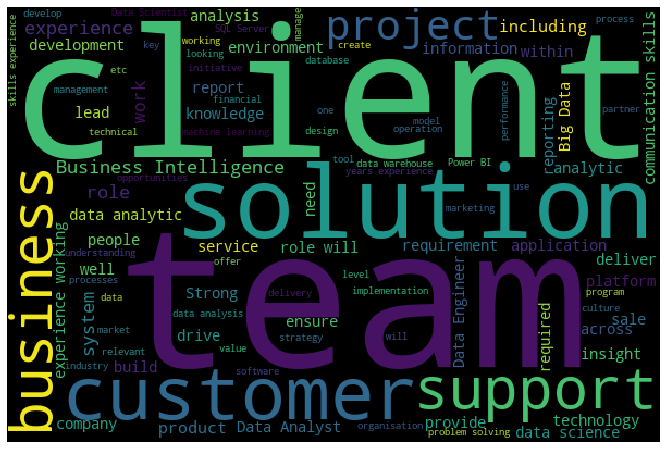

In [19]:
# Plotting a word cloud for job descriptions
text = ''
for i in df.index:
    text = text + df.jobDesc[i] + ' '
    
wordcloud = WordCloud(max_words=100, width=600, height=400).generate(text)

plt.rcParams['figure.figsize'] = 12, 8
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Modeling

## How job descriptions and titles impact salary
The data is labelled in `salaryHigh` according to the median wage as threshold. Random Forest and SVM classifiers are used to determine key phrases in job description and titles that distinguish high paying jobs from low.

In [8]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from textblob import TextBlob, Word
from nltk.stem.snowball import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.svm import SVC,LinearSVC

In [13]:
df.hiddenSalary.value_counts()

90000     312
100000    172
80000     121
110000    121
120000     71
130000     58
70000      53
140000     36
160000     29
150000     21
60000      21
170000     20
180000     16
50000       8
200000      7
190000      6
210000      3
220000      3
230000      1
240000      1
30000       1
Name: hiddenSalary, dtype: int64

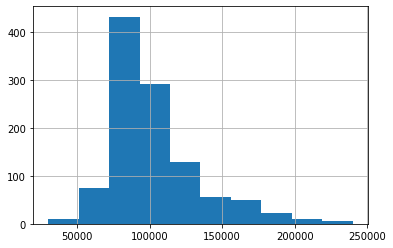

In [9]:
df.hiddenSalary.hist()

In [10]:
threshold = df.hiddenSalary.median()
for i in df.index:
    if df.loc[i,'hiddenSalary'] >= threshold:
        df.loc[i,'salaryHigh'] = 1
    else:
        df.loc[i,'salaryHigh'] = 0

In [358]:
# def lemmatize_string(text):
#     string = str()
#     text = str(text).lower()
#     words = TextBlob(text).words
#     for word in words:
#         string = string+' '+word.lemmatize()
#     return string

# def stemmer_string(text):
#     string = str()
#     stemmer = SnowballStemmer('english')
#     for word in text.split():
#         string = string+' '+stemmer.stem(word)
#     return string

# df.jobDesc = df.jobDesc.apply(lemmatize_string)
# df.jobDesc = df.jobDesc.apply(stemmer_string)

### The effect of job description on salary - Random Forest
`X` will be the vectorizered job descriptions, `y` target will be whether it is a high salary job or not. Print out the most frequent phrases in each `y` category, as well as the most important features according to the random forest model.

In [28]:
X=df.jobDesc
y=df.salaryHigh
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

In [29]:
# Test data baseline
y_test.value_counts(normalize=True).max()

0.5276752767527675

In [59]:
vect = TfidfVectorizer(stop_words='english',ngram_range=(1,3))
# vect = CountVectorizer(stop_words='english',ngram_range=(1,3),binary=True)
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

In [60]:
rfc = RandomForestClassifier(n_estimators=500,max_depth=10,max_leaf_nodes=50)
rfc.fit(X_train_dtm,y_train)
print('Train set score %f, test set score %f' % \
      (metrics.f1_score(y_train,rfc.predict(X_train_dtm)),
       metrics.f1_score(y_test,rfc.predict(X_test_dtm))))

Train set score 0.989399, test set score 0.750000


In [61]:
rfc_importance = pd.DataFrame({'Features':vect.get_feature_names(),
                               'Importance':rfc.feature_importances_})

print('The most important features are '+\
      str(rfc_importance.sort_values(by='Importance',ascending=False).head(15).Features.tolist()))

The most important features are ['analyst', 'excel', 'enterprise', 'experience', 'transformation', 'big', 'data analyst', 'successful', 'analysing', 'big data', 'skills ability', 'python', 'machine', 'solution', 'leadership']


In [62]:
def get_tf_phrase(vect,X,y,estimator,feature_len):
    '''
    Input the estimator, orignal X and y, vectorizer and print out the most frequent phrases in catergories
    where label == 1 or 0 in deseneding order. Phrases presented in both catergories are removed.
    '''
    # Define a TF predictor matrix and concat it with the label
    tf = pd.concat([pd.DataFrame(vect.transform(X).toarray(), columns=vect.get_feature_names()),
                    #pd.DataFrame({'pred':estimator.predict(vect.transform(X))})],axis=1)
                    pd.DataFrame(y.values, columns=['pred'])],axis=1)
    # Use list so the order is preserved
    one = list(tf[tf.pred == 1].drop('pred',axis=1).sum().sort_values(ascending=False).head(feature_len).index)
    zero = list(tf[tf.pred == 0].drop('pred',axis=1).sum().sort_values(ascending=False).head(feature_len).index)
    # Convert to set to get the intersection, which can be subtracted
    print('The most frequent phrases where label == 1 are ' + \
          str([s for s in one if s not in list(set(one).intersection(set(zero)))]),end='\n\n')
    print('The most frequent phrases where label == 0 are ' + \
        str([s for s in zero if s not in list(set(one).intersection(set(zero)))]))

In [63]:
get_tf_phrase(vect,X_train,y_train,rfc,50)

The most frequent phrases where label == 1 are ['big', 'big data', 'financial', 'science', 'aws', 'technology', 'learning', 'cloud', 'using', 'company', 'models', 'engineer', 'years', 'business intelligence', 'projects', 'azure', 'stakeholders']

The most frequent phrases where label == 0 are ['analyst', 'opportunity', 'data analyst', 'systems', 'including', 'people', 'quality', 'required', 'develop', 'environment', 'contract', 'insights', 'provide', 'reports', 'communication', 'looking', 'analytical']


### The effect of job description on salary - SVM
Print out the most frequent phrases in each y category, as well as features with the most positive and negative coefficients according to the SVM model.

In [64]:
svc = LinearSVC(max_iter=200)
svc.fit(X_train_dtm,y_train)
print('Train set score %f, test set score %f' % \
      (metrics.f1_score(y_train,svc.predict(X_train_dtm)),
       metrics.f1_score(y_test,svc.predict(X_test_dtm))))

Train set score 1.000000, test set score 0.759076


In [65]:
get_tf_phrase(vect,X_train,y_train,svc,50)

The most frequent phrases where label == 1 are ['big', 'big data', 'financial', 'science', 'aws', 'technology', 'learning', 'cloud', 'using', 'company', 'models', 'engineer', 'years', 'business intelligence', 'projects', 'azure', 'stakeholders']

The most frequent phrases where label == 0 are ['analyst', 'opportunity', 'data analyst', 'systems', 'including', 'people', 'quality', 'required', 'develop', 'environment', 'contract', 'insights', 'provide', 'reports', 'communication', 'looking', 'analytical']


In [66]:
svc_coef = pd.DataFrame({
    'Features':vect.get_feature_names(),
    'Coef':svc.coef_.reshape(svc.coef_.shape[1],)
})

print('Features with highest coefs are '+\
      str(svc_coef.sort_values(by='Coef',ascending=False).Features.head(15).tolist()),end='\n\n')
print('Features with lowest coefs are '+str(svc_coef.sort_values(by='Coef').Features.head(15).tolist()))

Features with highest coefs are ['bi', 'business', 'experience', 'big data', 'big', 'senior', 'financial', 'aws', 'leading', 'lead', 'drive', 'models', 'envato', 'sap', 'leadership']

Features with lowest coefs are ['analyst', 'excel', 'salesforce', 'graduate', 'data analyst', 'data analysis', 'work', 'candidates', 'analytical', 'offer', 'need', 'making', 'analysing', 'reports', 'demonstrated']


### The effect of titles on salary - Random Forest
`X2` will be vectorizered title. Since titles are much shorter, `ngram_range` will be (1,3) instead.

In [67]:
X2=df.jobTitle
y2=df.salaryHigh
X2_train, X2_test, y2_train, y2_test = train_test_split(X2,y2,random_state=42)

In [68]:
vect2 = TfidfVectorizer(stop_words='english',ngram_range=(1,3),min_df=2)
# vect2 = CountVectorizer(stop_words='english',ngram_range=(1,3),binary=True)

X2_train_dtm = vect2.fit_transform(X2_train)
X2_test_dtm = vect2.transform(X2_test)

In [69]:
rfc2 = RandomForestClassifier(n_estimators=500,max_depth=20,max_leaf_nodes=100)
rfc2.fit(X2_train_dtm,y2_train)
print('Train set score %f, test set score %f' % \
      (metrics.f1_score(y2_train,rfc2.predict(X2_train_dtm)),
       metrics.f1_score(y2_test,rfc2.predict(X2_test_dtm))))

Train set score 0.843292, test set score 0.709459


In [70]:
get_tf_phrase(vect2,X2_train,y2_train,rfc2,40)

The most frequent phrases where label == 1 are ['senior data engineer', 'lead', 'senior data scientist', 'bi developer', 'big data', 'big', 'big data engineer', 'business data', 'business data analyst', 'lead data', 'warehouse', 'data warehouse', 'technical', 'business development', 'development', 'financial', 'sql developer', 'architect', 'contract']

The most frequent phrases where label == 0 are ['graduate', 'junior', 'data analyst developer', 'analyst developer', 'spatial data', 'spatial', 'tableau', 'reporting', 'junior data', 'sydney', 'marketing', 'business intelligence developer', 'intelligence developer', 'research', 'spatial data analyst', 'level', 'bi analyst', 'modeller', 'digital']


In [71]:
rfc2_importance = pd.DataFrame({'Features':vect2.get_feature_names(),
                                'Importance':rfc2.feature_importances_})

print('The most important features are '+\
      str(rfc2_importance.sort_values(by='Importance',ascending=False).head(15).Features.tolist()))

The most important features are ['analyst', 'data analyst', 'data', 'senior', 'senior data', 'engineer', 'data engineer', 'business', 'manager', 'lead', 'bi', 'graduate', 'business intelligence', 'intelligence', 'senior data engineer']


### The effect of titles on salary - SVM

In [72]:
svc2 = LinearSVC()
svc2.fit(X2_train_dtm,y2_train)
print('Train set score %f, test set score %f' % \
      (metrics.f1_score(y2_train,svc2.predict(X2_train_dtm)),
       metrics.f1_score(y2_test,svc2.predict(X2_test_dtm))))

Train set score 0.845977, test set score 0.686869


In [83]:
get_tf_phrase(vect2,X2_train,y2_train,svc2,30)

The most frequent phrases where label == 1 are ['senior data engineer', 'lead', 'senior data scientist', 'bi developer', 'sql', 'big data', 'big', 'big data engineer', 'business data', 'business data analyst']

The most frequent phrases where label == 0 are ['graduate', 'junior', 'data analyst developer', 'analyst developer', 'spatial data', 'spatial', 'tableau', 'reporting', 'junior data', 'sydney']


In [80]:
svc_coef2 = pd.DataFrame({
    'Features':vect2.get_feature_names(),
    'Coef':svc2.coef_.reshape(svc2.coef_.shape[1],)
})

print('Features with highest coefs are '+\
      str(svc_coef2.sort_values(by='Coef',ascending=False).Features.head(10).tolist()),end='\n\n')

print('Features with lowest coefs are '+ str(svc_coef2.sort_values(by='Coef').Features.head(10).tolist()))

Features with highest coefs are ['marketing analytics', 'bi developer', 'contract', 'infrastructure', 'consultant data analytics', 'commercial', 'solution', 'bi consultant', 'lead data', 'cloud']

Features with lowest coefs are ['graduate', 'analyst banking', 'etl', 'microsoft bi', 'digital data', 'tableau developer', 'analyst', 'senior business intelligence', 'security', 'intern']


## How job descriptions distinguish data scientists from other data jobs
The data is labelled in `dataScientist` weather or not the jobTitle is dataScientist. Random Forest and SVM classifiers are used to distinguish data scientists from other data jobs.

In this section, data scientists jobs only consists about 13% of total jobs. The dataset is highly unbalanced, leading to low test accuracy. RandomOverSampler is used to oversample by simply duplicating under-represented samples. However, this will also increase the frequency of the words associated with data scientists in the TF-IDF matrix. TfidfVectorizer can be used to penalize commonly used words, hopefully, it will somewhat cancel out the effect of oversampling.


In [11]:
sci_index = df[pd.DataFrame(df['jobTitle'].str.lower())[['jobTitle']].\
   apply(lambda row: row.astype(str).str.contains('scientist').any(), axis=1)].index

In [12]:
for i in df.index:
    if i in sci_index:
        df.loc[i,'dataScientist'] = 1
    else:
        df.loc[i,'dataScientist'] = 0

### Modelling with unbalnced data directly

In [13]:
X3 = df[['jobDesc']]
y3 = df.dataScientist
# Baseline
y3.value_counts(normalize=True).max()

0.877890841813136

In [14]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3.jobDesc,y3,random_state=42)

In [16]:
vect3 = TfidfVectorizer(stop_words='english',ngram_range=(2,3))

X3_train_dtm = vect3.fit_transform(X3_train)
X3_test_dtm = vect3.transform(X3_test)

In [17]:
rfc3 = RandomForestClassifier(n_estimators=500,max_depth=18,max_leaf_nodes=100)
rfc3.fit(X3_train_dtm,y3_train)
print('Train set score %f, test set score %f' % \
      (metrics.f1_score(y3_train,rfc3.predict(X3_train_dtm)),
       metrics.f1_score(y3_test,rfc3.predict(X3_test_dtm))))

Train set score 0.548148, test set score 0.300000


### Balance dataset via RandomOverSampler
The f1 score without balancing the data is poor and below the baseline accuracy, balance the dataset is necessary.

In [18]:
# The dataset is unbalanced, use RandomOverSampler to oversample label == 1
from imblearn.over_sampling import RandomOverSampler # pip install -U imbalanced-learn

X3_resampled, y3_resampled = RandomOverSampler().fit_resample(X3, y3)
# New Baseline
y3_resampled.value_counts(normalize=True).max()

0.5

In [19]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3_resampled.jobDesc,y3_resampled,random_state=42)

In [20]:
vect3 = TfidfVectorizer(stop_words='english',ngram_range=(2,3))

X3_train_dtm = vect3.fit_transform(X3_train)
X3_test_dtm = vect3.transform(X3_test)

### The effect of job description - Random Forest

In [617]:
rfc3 = RandomForestClassifier(n_estimators=500,max_depth=25,max_leaf_nodes=100)
rfc3.fit(X3_train_dtm,y3_train)
print('Train set score %f, test set score %f' % \
      (metrics.f1_score(y3_train,rfc3.predict(X3_train_dtm)),
       metrics.f1_score(y3_test,rfc3.predict(X3_test_dtm))))

Train set score 0.988104, test set score 0.968468


In [618]:
rfc3_importance = pd.DataFrame({'Features':vect3.get_feature_names(),
                                'Importance':rfc3.feature_importances_})
print('The most important features are '+\
      str(rfc3_importance.sort_values(by='Importance',ascending=False).head(15).Features.tolist()))

The most important features are ['data scientist', 'machine learning', 'business intelligence', 'data science', 'computer science', 'machine learning algorithms', 'data scientist join', 'predictive models', 'data mining', 'learning models', 'deep learning', 'structured unstructured data', 'statistics computer science', 'looking data scientist', 'learning algorithms']


In [620]:
get_tf_phrase(vect3,X3_train,y3_train,rfc3,20)

The most frequent phrases where label == 1 are ['data science', 'machine learning', 'data scientist', 'computer science', 'design develop', 'design develop implement', 'develop implement', 'data mining', 'analytical solution', 'deep learning', 'solve complex', 'predictive models', 'data sets', 'privacy policy', 'envato com', 'years experience']

The most frequent phrases where label == 0 are ['business intelligence', 'data analyst', 'data engineer', 'data warehouse', 'power bi', 'experience working', 'communication skills', 'data analysis', 'business analyst', 'skills experience', 'sql server', 'data management', 'data migration', 'data modelling', 'month contract', 'data quality']


### The effect of job description - SVM

In [621]:
svc3 = LinearSVC()
svc3.fit(X3_train_dtm,y3_train)
print('Train set score %f, test set score %f' % \
      (metrics.f1_score(y3_train,svc3.predict(X3_train_dtm)),
       metrics.f1_score(y3_test,svc3.predict(X3_test_dtm))))

Train set score 0.998619, test set score 1.000000


In [88]:
get_tf_phrase(vect3,X3_train,y3_train,svc3,20)

The most frequent phrases where label == 1 are ['data science', 'machine learning', 'data scientist', 'computer science', 'data mining', 'predictive models', 'deep learning', 'data sets', 'design develop', 'data scientist join', 'scientist join', 'mathematics statistics', 'learning models', 'cutting edge', 'data scientists', 'structured unstructured']

The most frequent phrases where label == 0 are ['business intelligence', 'data analyst', 'data warehouse', 'power bi', 'data engineer', 'experience working', 'communication skills', 'data analysis', 'skills experience', 'sql server', 'business analyst', 'years experience', 'data management', 'data modelling', 'data migration', 'month contract']


In [85]:
svc_coef3 = pd.DataFrame({
    'Features':vect3.get_feature_names(),
    'Coef':svc3.coef_.reshape(svc3.coef_.shape[1],)
})

print(svc_coef3.sort_values(by='Coef',ascending=False).Features.head(10).tolist(),end='\n\n')
print(svc_coef3.sort_values(by='Coef').Features.head(10).tolist())

['data scientist', 'data science', 'machine learning', 'computer science', 'deep learning', 'data mining', 'predictive models', 'learning models', 'mathematics statistics', 'cutting edge']

['business intelligence', 'data engineer', 'data analyst', 'business analyst', 'data warehousing', 'data management', 'power bi', 'data warehouse', 'data modelling', 'data solutions']
